### References

kaggle notebook discussing classification of time signals 
https://www.kaggle.com/code/kellibelcher/time-series-classification-with-lstms-sensor-eda#Data-Overview 

# Capnogram Time Series Classification Project

## Initialisation

In [1]:
import time
notebook_start_time = time.time()

# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import scipy.stats as sp
import shap

original_dataset = pd.read_json('./capnogram_project_data.json')
dataset = original_dataset.copy()

## 1: Prelim Investigation and Data Cleaning

### 1.1: Prelim Investigation

In [2]:
# have a preliminary look! 
print('dataset details\n\nrow count: {} \ncolumn count: {} \n\ncolumn names, dtypes: \n{}'.format(
    dataset.shape[0], dataset.shape[1], dataset.dtypes))

dataset.head()

dataset details

row count: 1130 
column count: 4 

column names, dtypes: 
participant_id     int64
breath            object
label              int64
sex               object
dtype: object


,participant_id,breath,label,sex
0,76,"[0.049769140600000004, 0.050671308400000004, 0...",1,M
1,24,"[0.0484644411, 0.050810562600000005, 0.0516038...",0,F
2,15,"[0.0489304584, 0.057132044300000004, 0.0636871...",0,F
3,21,"[0.048927833000000004, 0.0519550774, 0.0517339...",0,M
4,91,"[0.0507470406, 0.0501178251, 0.050242884800000...",1,F


In [3]:
# empty entries? 
print('missing entries for each column: \n{}'.format(
    dataset.isnull().sum()))

missing entries for each column: 
participant_id     0
breath             0
label              0
sex               21
dtype: int64


In [4]:
# empty entries: old:

# # check for NaN or None values using .isnull()
# col_names = dataset.columns
# bad_cols = []

# for col_name in col_names:
    
#     if dataset[col_name].isnull().any():
        
#         bad_cols.append(col_name)
#         missing_count = dataset[col_name].isnull().sum()
#         print(col_name + ' column is missing ' + str(missing_count) + ' values.')

### 1.2: Filling Missing Sex Entries

- All entries that have their sex imply the sex of that unique participant. 
- If that participant has another entry without sex listed, we can infer from this previous entry
- set(ID's without sex) - set(ID's with sex) gives the set of ID numbers that we cant infer!

In [5]:
# are no sex IDs all contained within sex IDs?
no_sex_IDs = dataset['participant_id'][dataset['sex'].isnull()]
yes_sex_IDs = dataset['participant_id'][dataset['sex'].notna()]

print('no_sex_IDs is a subset of yes_sex_IDs: {}'.format(
    no_sex_IDs.isin(yes_sex_IDs).all()))

no_sex_IDs is a subset of yes_sex_IDs: True


**Therefore we can infer all missing sex entries!**

In [6]:
# fill empty sex information, then check 1) no missing info, 2) dataset same shape 

# make dataframe for FILLED sex rows, containing participant_id and sex columns, with no duplicates. 
sex_mapping = dataset.loc[dataset['sex'].notna(), ['participant_id', 'sex']].drop_duplicates()

# Merge dataset and sex_mapping
dataset = dataset.merge(sex_mapping, on='participant_id', # combine with same participant_id
                        how='left', # left merge: keeps all dataset rows,
                        suffixes=('', '_filled')) # add suffixes to stop column name confusion

# then fill missing sex values from sex_filled column. then drop sex_filled column
dataset['sex'].fillna(dataset['sex_filled'], inplace=True)
dataset.drop(columns=['sex_filled'], inplace=True)

In [7]:
# check no missing info, same shape

# empty entries? 
print('missing entries for each column: \n{}\n'.format(
    dataset.isnull().sum()))

print('original dataset shape: {} \ncurrent dataset shape: {}'.format(
    original_dataset.shape, dataset.shape))

missing entries for each column: 
participant_id    0
breath            0
label             0
sex               0
dtype: int64

original dataset shape: (1130, 4) 
current dataset shape: (1130, 4)


In [8]:
# fill empty sex information (old)

# sex_list = []
# id_without_sex_list = list(ids_without_sex_set)

# for i, id_num in enumerate(id_without_sex_list):
    
#     id_data = dataset[dataset['participant_id'] == id_num]
    
#     sex_data = list(
#         id_data['sex'][
#             (id_data['sex'] == 'M') | (id_data['sex']== 'F')
#         ])

#     sex_list.append(sex_data[0])

# print('IDs missing sex:')
# print(id_without_sex_list)
# print('\n' + 'Corresponding sex:')
# print(sex_list)

# # find missing sex indices and then fill, for each id_number
# for i, id_num in enumerate(id_without_sex_list):
    
#     id_indices = dataset[dataset['participant_id'] == id_num].index
    
#     for index in id_indices:
#         dataset.loc[index, 'sex'] = sex_list[i]
        
# # re-check if any missing values:
# null_count = pd.DataFrame([dataset[col_name].isnull().any() for col_name in dataset.columns]).sum()[0]

# if (not null_count) > 0: 
#     print('No columns missing data!' + '\n')
    
# # same shape as before?
# if (original_dataset.shape == dataset.shape):
#     print('dataset is still same shape!')
# else:
#     print('changed shape...')

### 1.3: Further Cross Checks

- How many participants? 
- Are 'sex' and 'label' uniform across each participant?
- This having been done, are there any duplicate entries?

In [9]:
# how many candidates? 

print('Number of participants: {}'.format(
    dataset['participant_id'].nunique()))

Number of participants: 100


In [10]:
# does each participant only have one "sex" and 'label' characteristic?

# split dataset into groups by participant_id
grouped = dataset.groupby(by='participant_id')

# booleans for if every participant only has one sex and label listed
# checks that the number of unique values is no higher than one for any id_num
print('Each participant has only: \n\nOne sex listed: {} \nOne label listed: {}'.format(
    (grouped['sex'].nunique().unique().max() == 1),
    (grouped['label'].nunique().unique().max() == 1)))

Each participant has only: 

One sex listed: True 
One label listed: True


In [11]:
# (old) checking that each participant only has one sex and label identifier 

# check sex and label uniform for every participant
# uniform_bool = True
# for id_num in unique_ids:

#     ind_data = dataset[dataset['participant_id'] == id_num]
    
#     if not (( ind_data['sex'].nunique() == 1) and (ind_data['label'].nunique() == 1)):
#         print('at least one sex or label is changing!')
#         uniform_bool = False
#         break
        
#     # if not:
# if uniform_bool:
#     print('all participants have uniform sex and label across their entries!')

In [12]:
# (old) plotting pie chart of M vs F numbers, plotting bar graph of number of rows for each candidate 

# sex_labels = ['M', 'F']
# sex_appearances = [(dataset['sex'] == sex).sum()
#                   for sex in sex_labels]

# # count id totals
# unique_ids = np.sort(
#     dataset['participant_id'].unique()) # ascending order
# id_appearances = [(dataset['participant_id'] == id_num).sum()
#                   for id_num in unique_ids]
# # create fig for two plots
# fig, axes = plt.subplots(nrows=2, figsize=(10, 6))  # Define figure and axis

# # create pie chart
# axes[0].pie(sex_appearances, labels=sex_labels, autopct='%1.1f%%', startangle=140, 
#        colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'});
# axes[0].set_title('Sex Distribution')

# # Add title and labels
# axes[1].set_title("Count for Each Candidate")
# axes[1].set_xlabel("Candidate id")
# axes[1].set_ylabel("Number of Entries")
# # axes[1].set_ylim(ymin=0,ymax=11)
# axes[1].plot(unique_ids, id_appearances)

# # Show plot
# plt.show()

In [13]:
# Are there any duplicate entries? 

# cast each breath time_series as a tuple, to allow hashability
duplicate_test_dataset = dataset.copy()
duplicate_test_dataset['breath'] = duplicate_test_dataset['breath'].apply(tuple)

# count number of duplicate rows
print('Number of duplicate rows: {}'.format(
    duplicate_test_dataset.duplicated().sum()))

Number of duplicate rows: 0


### 1.4: Making All Features Readable

'Sex' will need one hot encoding! 

In [14]:
trial_ds = dataset

# create onehot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# one hot encode
OH_cols_sex = pd.DataFrame(OH_encoder.fit_transform(trial_ds[['sex']]))

# put back indices
OH_cols_sex.index = trial_ds['sex'].index
# rename columns 
OH_cols_sex = OH_cols_sex.rename(columns={
    0: 'female OH',
    1: 'male OH'
})

# concat data and OH
new_ds = pd.concat([trial_ds, OH_cols_sex], axis=1)
sex_data = new_ds['sex']
new_ds = new_ds.drop('sex', axis=1)

dataset = new_ds

In [15]:
# make sure column names are good
dataset.head()

,participant_id,breath,label,female OH,male OH
0,76,"[0.049769140600000004, 0.050671308400000004, 0...",1,0.0,1.0
1,24,"[0.0484644411, 0.050810562600000005, 0.0516038...",0,1.0,0.0
2,15,"[0.0489304584, 0.057132044300000004, 0.0636871...",0,1.0,0.0
3,21,"[0.048927833000000004, 0.0519550774, 0.0517339...",0,0.0,1.0
4,91,"[0.0507470406, 0.0501178251, 0.050242884800000...",1,1.0,0.0


In [16]:
# check dtypes are now all numeric, or object for breath
dataset.dtypes

participant_id      int64
breath             object
label               int64
female OH         float64
male OH           float64
dtype: object

looks good!

## 2: Investigating 'Breath' Time Series

### 2.1: Preliminary Investigation into Breath Time Series

Plot the first few 'breaths' below:

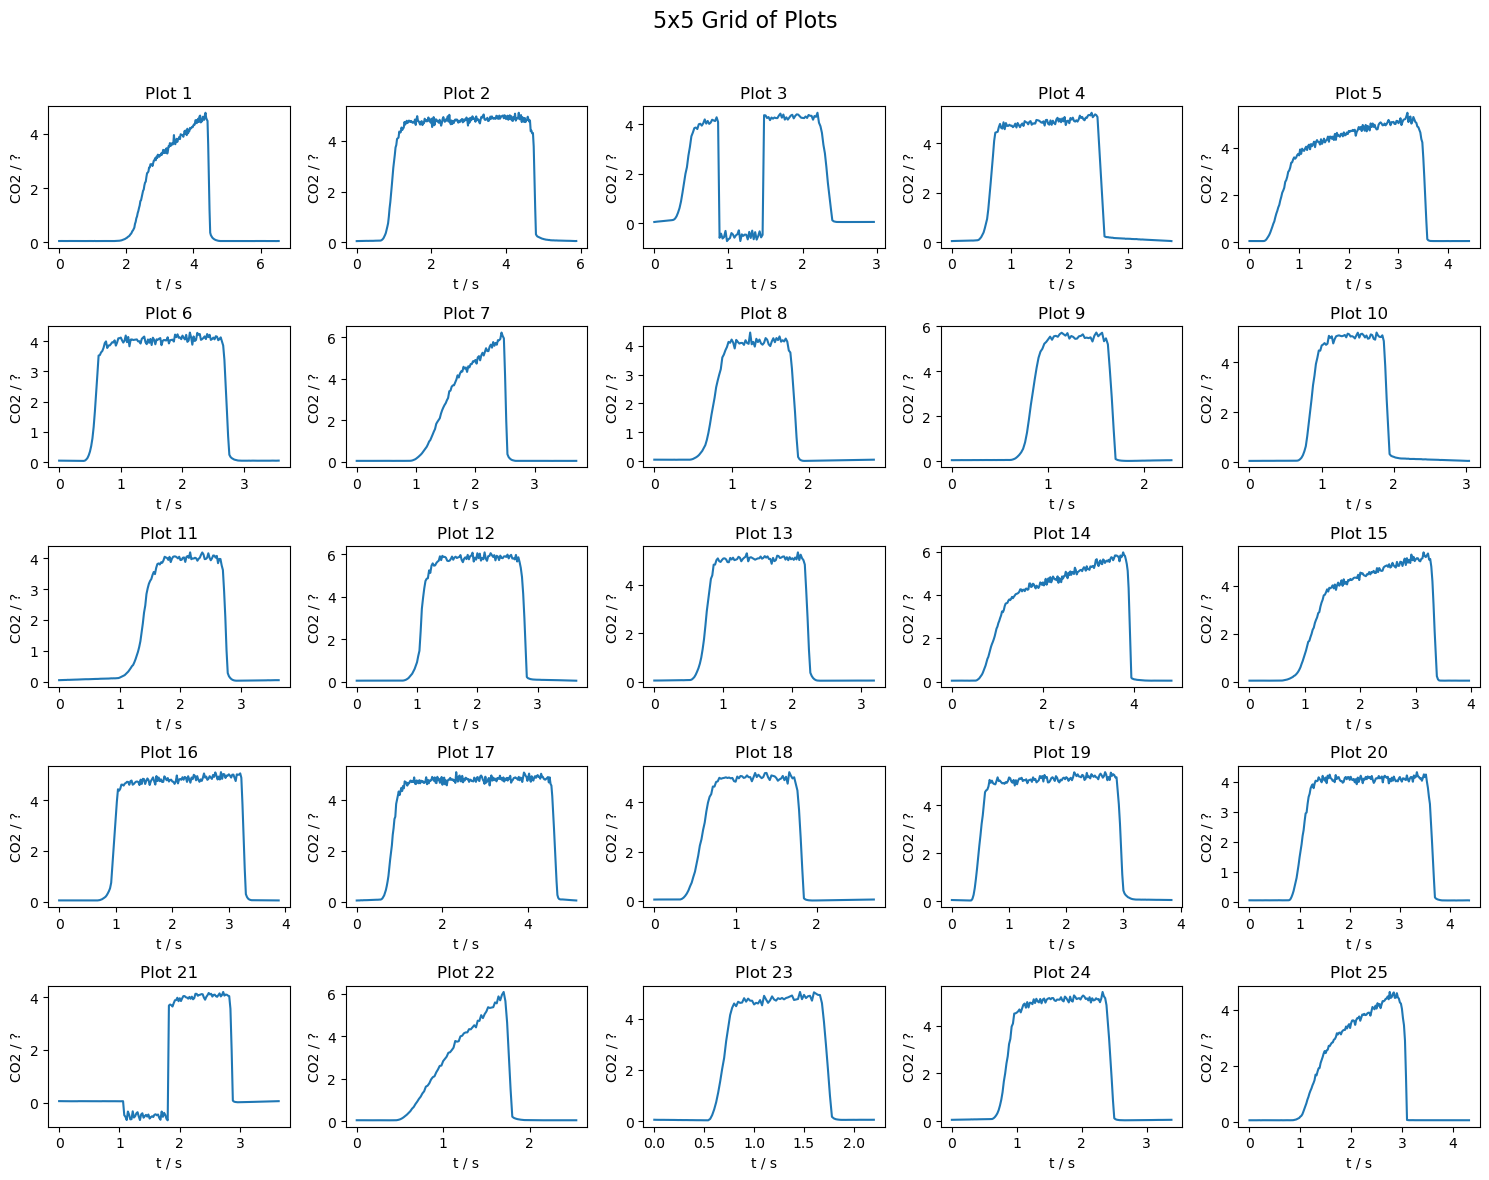

In [17]:
# making a list of the first 30 time series 
CO2_data = [dataset['breath'][i] for i in range(0,30)]

# creating time data at 50Hz for each time series 
t_data = [np.arange(0,len(series)) / 50
    for series in CO2_data]

# Create a 5x2 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))
fig.suptitle("5x5 Grid of Plots", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot data using Seaborn on each subplot
for i, ax in enumerate(axes):
    sns.lineplot(ax=ax, y=CO2_data[i], x=t_data[i])
    ax.set_title(f"Plot {i+1}")
    ax.set_xlabel("t / s")
    ax.set_ylabel("CO2 / ?")
    ax.set_xlim()

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Preliminary thoughts: 

1) 
negative values, i.e. below the original baseline of zero dont make sense, as
- baseline of zero represents an inhale, and should be the same as background readings, assuming uniform room gas distribution. 
••Solution: ignore capnograms with negative CO2 values••

2) 
there is noise during full exhales, i.e. random movement at the peak of CO2. 
**Could ignore this noise, and use a moving average to find the overall trend?**

3) 
some capnograms are bell shaped, others appear to be skewed! 
**can we feature engineer these effects?**

### 2.2: Moving Average Transformation (preprocessing 2)

In [18]:
# process list data

def moving_average(time_series_list, WINDOW=10, CENTER=True):
    
    # convert list to pd.series, then apply rolling average code 
    time_series = pd.Series(time_series_list)
    moving_average = time_series.rolling(
        window=WINDOW,       
        center=CENTER,      
        min_periods=int(WINDOW/2),  
    ).mean()   
    
    # finally remove inevitable nulls
    moving_average = moving_average[~moving_average.isnull()]
    
    return moving_average.to_list()


# make sure no Nulls, all numeric
def no_nulls(inp_list):
    
    series = pd.Series(inp_list)
    
    # drop nulls, cast as numeric
    series = series.dropna()
    series = series.astype(float)
    
    return series.to_list()
    
def pos_bool_mask(inp_list):
    if np.min(inp_list) < 0:
        return False
    else:
        return True
    
def time_range_calc(timeseries_list, freq=50, threshold_frac=0.05):
    
    # make array
    array = np.array(timeseries_list)
    
    # find minimum value considered nonzero, given frac of max-min
    threshold_val = threshold_frac * (np.max(array) - np.min(array))
    
    # mask for values over threshold
    # values are already in time order
    # first and last values are the first and last at the threshold, i.e. start and end of series
    over_thresh_array = array[array > threshold_val]
    
    # time elapsed (s) is (num_vals - 1) / freq (Hz)
    total_time_elapsed = (len(over_thresh_array) - 1) / freq
    
    return total_time_elapsed

def redefine_series(func_array, series):
    for func in func_array:
        series = series.apply(func)
        pd.Series(series[0]).plot();
    return series

def range_val(inp_list):
    array = np.array(inp_list)
    return (np.max(array) - np.min(array))

#### Applying Time Preprocessing

In [19]:
# (old!) dataset = original_dataset.copy()

# # load lists into Series
# breath_data = dataset['breath']

# # PREPROCESSING FUNCTIONS
# dataset['breath'] = dataset['breath'].apply(no_nulls)
# dataset = dataset[dataset['breath'].apply(pos_bool_mask)]
# dataset['breath'] = dataset['breath'].apply(moving_average)
# # # now no nulls, only positive series, and time averaged! 
# # # checked, seems okay for breath_data[0]:)

# # FEATURE FUNCTIONS
# feature_funcs = [range_val, time_range_calc]
# feature_labels = ['CO2 range', 'time duration']

# # calculate feature series:
# feature_series_list = []
# for func in feature_funcs:
#     feature_series_list.append(
#         dataset['breath'].apply(func).to_list())
    
# # transpose feature series list to make the features for each series on the same row
# feature_series_array = np.array(feature_series_list).transpose()

# # put together into df
# time_feature_df = pd.DataFrame(data=feature_series_array,
#                               columns=feature_labels)
      
# # check indices
# time_feature_df.index = dataset.index

# # concat dataset and new time features 
# dataset = pd.concat([dataset, time_feature_df], axis=1)

# # reset indices
# dataset.index = range(0,dataset.shape[0])

## 3: Time Series Feature Engineering 

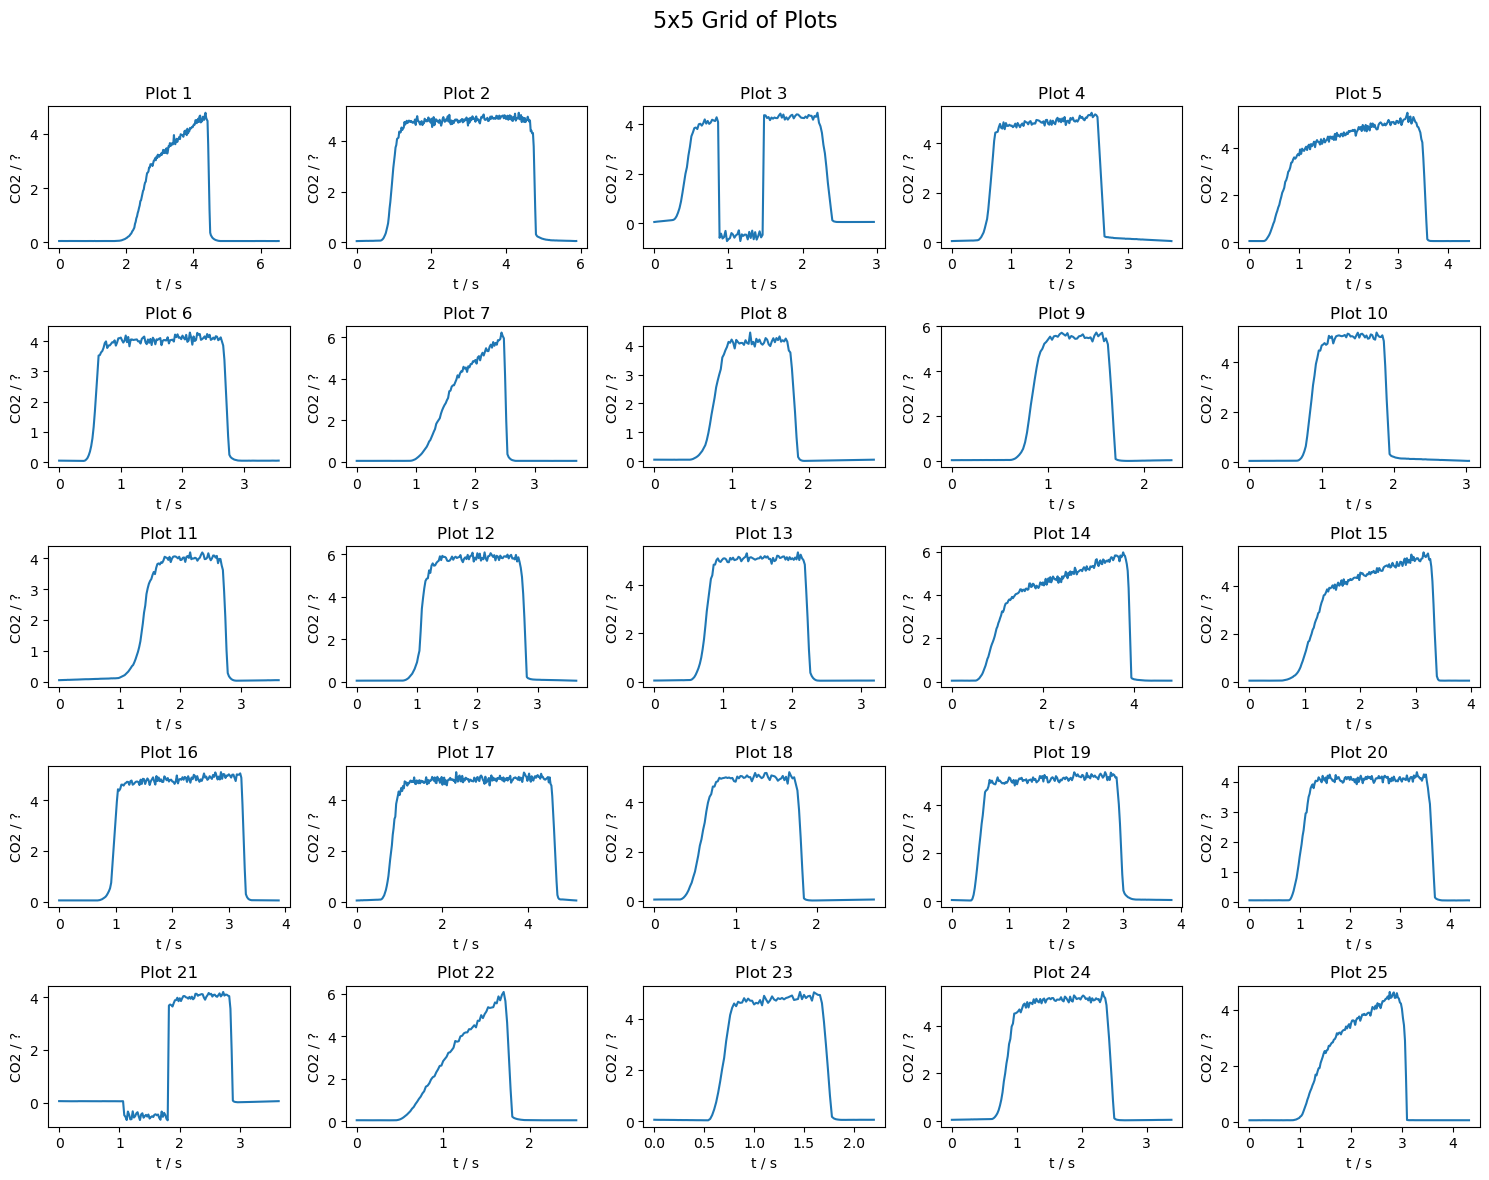

In [20]:
# making a list of the first 30 time series 
CO2_data = [list(dataset['breath'][i]) for i in range(0,30)]

# creating time data at 50Hz for each time series 
t_data = [np.arange(0,len(series)) / 50
    for series in CO2_data]

# Create a 5x2 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))
fig.suptitle("5x5 Grid of Plots", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot data using Seaborn on each subplot
for i, ax in enumerate(axes):
    sns.lineplot(ax=ax, y=CO2_data[i], x=t_data[i])
    ax.set_title(f"Plot {i+1}")
    ax.set_xlabel("t / s")
    ax.set_ylabel("CO2 / ?")
    ax.set_xlim()

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [21]:
def breath_feature_gen(dataset):
    
    breath_data = dataset['breath'].apply(np.array)
    
    func_array = [np.max, np.min, np.std, np.median, np.mean, sp.skew, sp.kurtosis]
    func_labels = ['max', 'min', 'std', 'median', 'mean', 'skew', 'kurtosis']
    output_array = []
    
    for i,func in enumerate(func_array):
        
        output = breath_data.apply(func).to_list()
        output_array.append(output)
    
    # make outputs into dataframe
    output_array = np.array(output_array)
    output_array = output_array.transpose()
    
    feature_df = pd.DataFrame(data=output_array, columns=func_labels)
    
    # make sure indices are same as dataset
    feature_df.index = dataset.index
    
    return feature_df

In [22]:
# (old) feature engineering code

# def breath_feature_gen(dataset):
#     # FEATURE FUNCTIONS
#     feature_funcs = [range_val, time_range_calc]
#     feature_labels = ['CO2 range', 'time duration']

#     # calculate feature series:
#     feature_series_list = []
#     for func in feature_funcs:
#         feature_series_list.append(
#             dataset['breath'].apply(func).to_list())
    
#     # transpose feature series list to make the features for each series on the same row
#     feature_series_array = np.array(feature_series_list).transpose()

#     # put together into df
#     time_feature_df = pd.DataFrame(data=feature_series_array,
#                                   columns=feature_labels)
#     # check indices
#     time_feature_df.index = dataset.index
#     # concat dataset and new time features 
#     dataset = pd.concat([dataset, time_feature_df], axis=1)
#     return dataset

In [23]:
# (old) def dataset_checks(dataset):
    
#     print('\ndataset details\n\nrow count: {} \ncolumn count: {} \n\ncolumn names, dtypes: \n{}'.format(
#     dataset.shape[0], dataset.shape[1], dataset.dtypes))
    
#     print('\nmissing entries for each column: \n{}'.format(
#         dataset.isnull().sum()))
    
#     grouped = dataset.groupby(by='participant_id')
#     print('Each participant has only: \n\nOne sex listed: {} \nOne label listed: {}'.format(
#         (grouped['sex'].nunique().unique().max() == 1),
#         (grouped['label'].nunique().unique().max() == 1)))

## 4) Applying ML Model

### 4.1: Setting Up Complete Preprocessing Pipeline

In [24]:
# non breath functions. 
# bundle: prelim_preprocessing(dataset)

def prelim_preprocessing(dataset):
    dataset = fill_sex_vals(dataset)
    return dataset

# non breath preprocessing funcs
def fill_sex_vals(dataset):
    sex_mapping = dataset.loc[dataset['sex'].notna(), ['participant_id', 'sex']].drop_duplicates()
    dataset = dataset.merge(sex_mapping, on='participant_id', 
                            how='left', 
                            suffixes=('', '_filled'))
    dataset['sex'].fillna(dataset['sex_filled'], inplace=True)
    dataset.drop(columns=['sex_filled'], inplace=True)
    return dataset

# OH encode sex column 
def OH_encode_sex_vals(dataset):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    OH_sex_df = pd.DataFrame(OH_encoder.fit_transform(dataset[['sex']]))
    OH_sex_df.index = dataset['sex'].index
    OH_sex_df = OH_sex_df.rename(columns={
        0: 'female OH',
        1: 'male OH'
    })
    
    return dataset, OH_sex_df

In [25]:
# breath preprocessing functions. 
# bundle: breath_preprocessing(dataset)

def breath_preprocessing(dataset):
    
    breath_data = dataset['breath'].apply(no_nulls)
    dataset = dataset[breath_data.apply(pos_bool_mask)]
    breath_data = dataset['breath'].apply(moving_average)
    
    dataset.loc[:,'breath'] = breath_data
    return dataset

def moving_average(time_series_list, MOVING_AV_WINDOW = 10, CENTER=True):
    
    # convert list to pd.series, then apply rolling average code 
    time_series = pd.Series(time_series_list)
    moving_average = time_series.rolling(
        window=MOVING_AV_WINDOW,       
        center=CENTER,      
        min_periods=int(MOVING_AV_WINDOW/2),  
    ).mean()   
    
    # finally remove inevitable nulls
    moving_average = moving_average[~moving_average.isnull()]
    
    return moving_average.to_list()


# make sure no Nulls, all numeric
def no_nulls(inp_list):
    
    series = pd.Series(inp_list)
    
    # drop nulls, cast as numeric
    series = series.dropna()
    series = series.astype(float)
    
    return series.to_list()

# make sure no Nulls, all numeric
def check_no_nulls(inp_list):
    
    series = pd.Series(inp_list)
    return series.isna().any()

    
def pos_bool_mask(inp_list):
    if np.min(inp_list) < 0:
        return False
    else:
        return True
    
def time_range_calc(timeseries_list, freq=50, threshold_frac=0.05):
    
    # make array
    array = np.array(timeseries_list)
    
    # find minimum value considered nonzero, given frac of max-min
    threshold_val = threshold_frac * (np.max(array) - np.min(array))
    
    # mask for values over threshold
    # values are already in time order
    # first and last values are the first and last at the threshold, i.e. start and end of series
    over_thresh_array = array[array > threshold_val]
    
    # time elapsed (s) is (num_vals - 1) / freq (Hz)
    total_time_elapsed = (len(over_thresh_array) - 1) / freq
    
    return total_time_elapsed

def redefine_series(func_array, series):
    for func in func_array:
        series = series.apply(func)
        pd.Series(series[0]).plot();
    return series

def range_val(inp_list):
    array = np.array(inp_list)
    return (np.max(array) - np.min(array))

In [26]:
# single feature engineering func
def feature_engineering(dataset):
    
    breath_data = dataset['breath'].apply(np.array)
    
    func_array = [np.max, np.min, np.std, np.median, np.mean, sp.skew, sp.kurtosis]
    func_labels = ['max', 'min', 'std', 'median', 'mean', 'skew', 'kurtosis']
    output_array = []
    
    for i,func in enumerate(func_array):
        
        output = breath_data.apply(func).to_list()
        output_array.append(output)
    
    # make outputs into dataframe
    output_array = np.array(output_array)
    output_array = output_array.transpose()
    
    feature_df = pd.DataFrame(data=output_array, columns=func_labels)
    
    # make sure indices are same as dataset
    feature_df.index = dataset.index
    
    # finally feature engineer sex
    dataset, OH_sex_df = OH_encode_sex_vals(dataset)
    
    # attach OH sex, and label, to feature df
    full_feature_df = pd.concat([feature_df, OH_sex_df, dataset['label']], axis=1)
    OH_sex_df.head()
    
    return full_feature_df

In [27]:
# full preprocessing bundle
def full_dataset_processing(dataset):

    dataset = prelim_preprocessing(dataset)
    dataset = breath_preprocessing(dataset)
    return dataset

In [28]:
# generate raw dataset
raw_dataset = original_dataset.copy()

# preprocess raw dataset
preprocessed_dataset = full_dataset_processing(raw_dataset)

# generate ML applicable features from preprocessed data set
full_feature_dataset = feature_engineering(preprocessed_dataset)

# get target data y, and feature data X
y = full_feature_dataset['label']
X = full_feature_dataset.drop(labels=['label'], axis=1)

### 4.2: Trial 1

- Worried about data from the same person making it into both training and validation sets. 
- Could learn personal characteristics about them
- Therefore use GroupKFold for cross validation

In [29]:
# setup GroupKFold Cross Validation
FOLDS = 5
# put participant_id col back into full_feature_dataset to allow grouping 
groups = preprocessed_dataset['participant_id']

def train_func(X,y):
    
    # initialise GroupKFold
    group_kfold = GroupKFold(n_splits=FOLDS)
    accuracy_list = []
    feature_importance_list = []
    final_estimator_list = []
    best_score_list = []
    
    # use groupkfold
    for i, (train_idx, valid_idx) in enumerate(group_kfold.split(X, y, groups=groups)):  
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # model
        early_stop = EarlyStopping(
            rounds=5, metric_name='logloss', data_name='validation_0', save_best=True
        )

        model = XGBClassifier(n_estimators=1000,
                             callbacks=[early_stop])

        # Fit the pipeline
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)
        
        final_estimator_list.append(model.best_iteration + 1)
        best_score_list.append(model.best_score)

        # Predict and evaluate
        y_pred = model.predict(X_valid)
        acc_score = accuracy_score(y_valid, y_pred, normalize=True)

        if i == 0:
            explainer = shap.Explainer(model)
            shap_values = explainer(X_train)
            shap.summary_plot(shap_values, X_train)

        feature_importances = model.feature_importances_

        accuracy_list.append(acc_score)
        feature_importance_list.append(feature_importances)
        
    return accuracy_list, feature_importance_list, final_estimator_list, best_score_list

In [30]:
def training_implementor(X,y):
    accuracy_list, feature_importance_list, estimator_number_list, best_score_list = train_func(X,y)
    mean_accuracy = np.mean(accuracy_list)
    mean_feature_importances = np.mean(feature_importance_list, axis=0)

    print(('Number of Folds: {} \nmean final accuracy Scores: {:.4f} \nmean final estimator: {:.0f}\n'
    + 'mean final logloss score: {:.4f}\n').format(
        FOLDS,
        mean_accuracy,
        np.mean(estimator_number_list),
        np.mean(best_score_list)))

    print('Feature Importances: \n')
    for i, feature_name in enumerate(X.columns):
        print('{}: {:.3f}'.format(feature_name,
                             mean_feature_importances[i]))

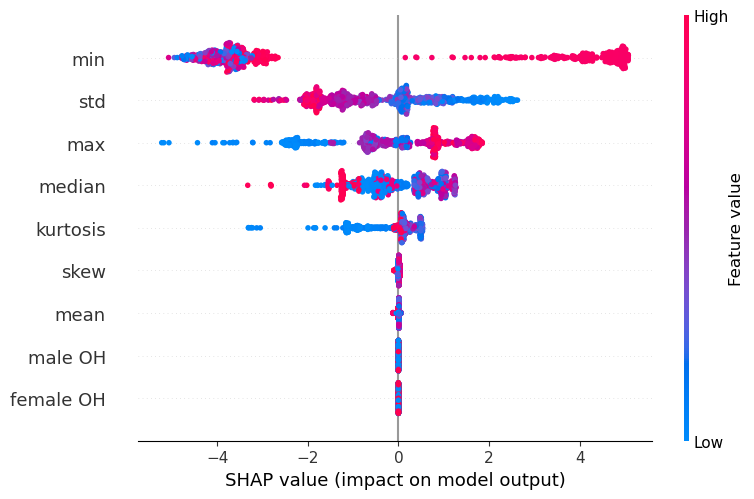

Number of Folds: 5 
mean final accuracy Scores: 0.9827 
mean final estimator: 34
mean final logloss score: 0.0422

Feature Importances: 

max: 0.054
min: 0.741
std: 0.055
median: 0.036
mean: 0.011
skew: 0.014
kurtosis: 0.083
female OH: 0.005
male OH: 0.000


In [31]:
training_implementor(X,y)

### 4.3: Trial 2

- strange that min is so highly rated, especially with context of every capnogram having baseline values that reflect the room, not the patient. Will therefore replace max, min, with range = (max-min)
- will drop sex, as fears of data leakage if sex and label are similarly skewed. 

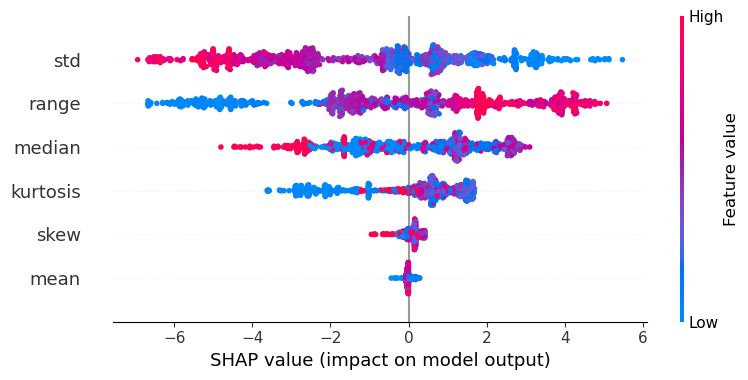

Number of Folds: 5 
mean final accuracy Scores: 0.9791 
mean final estimator: 41
mean final logloss score: 0.0658

Feature Importances: 

std: 0.123
median: 0.323
mean: 0.035
skew: 0.052
kurtosis: 0.283
range: 0.183


In [32]:
# make X changes
range_df = (X['max'] - X['min']).to_frame(name="range")
X_2 = X.drop(columns=['male OH', 'female OH', 'max', 'min'])
X_2 = pd.concat([X_2, range_df], axis=1)

# train again with X_2, y
training_implementor(X_2,y)

## 5: Back To Feature Engineering

- Realised no input metrics accounted for sequential nature of data...
- need characteristics like #peaks, #valleys, etc. 
- then could work out things like 1stOdiff, 2ndOdiff, i.e. (x_i+1 - x_i) / t (gradient)

1) go back to data investigation, see if I can group different curves 

2) once ^ is satisfied, try and engineer extra features mentioned above!

#### 5.1: Initial Random Graphing

In [33]:
dataset = original_dataset.copy()

In [34]:
# 16 random floats [0,1)
rand_floats = np.random.rand(16) * dataset.shape[0]
rand_ints = rand_floats.astype(int)
print(rand_ints)
# make them 

[ 606 1003 1034   41  810  833  697  136 1035  757  252  774  606  787
  686  819]


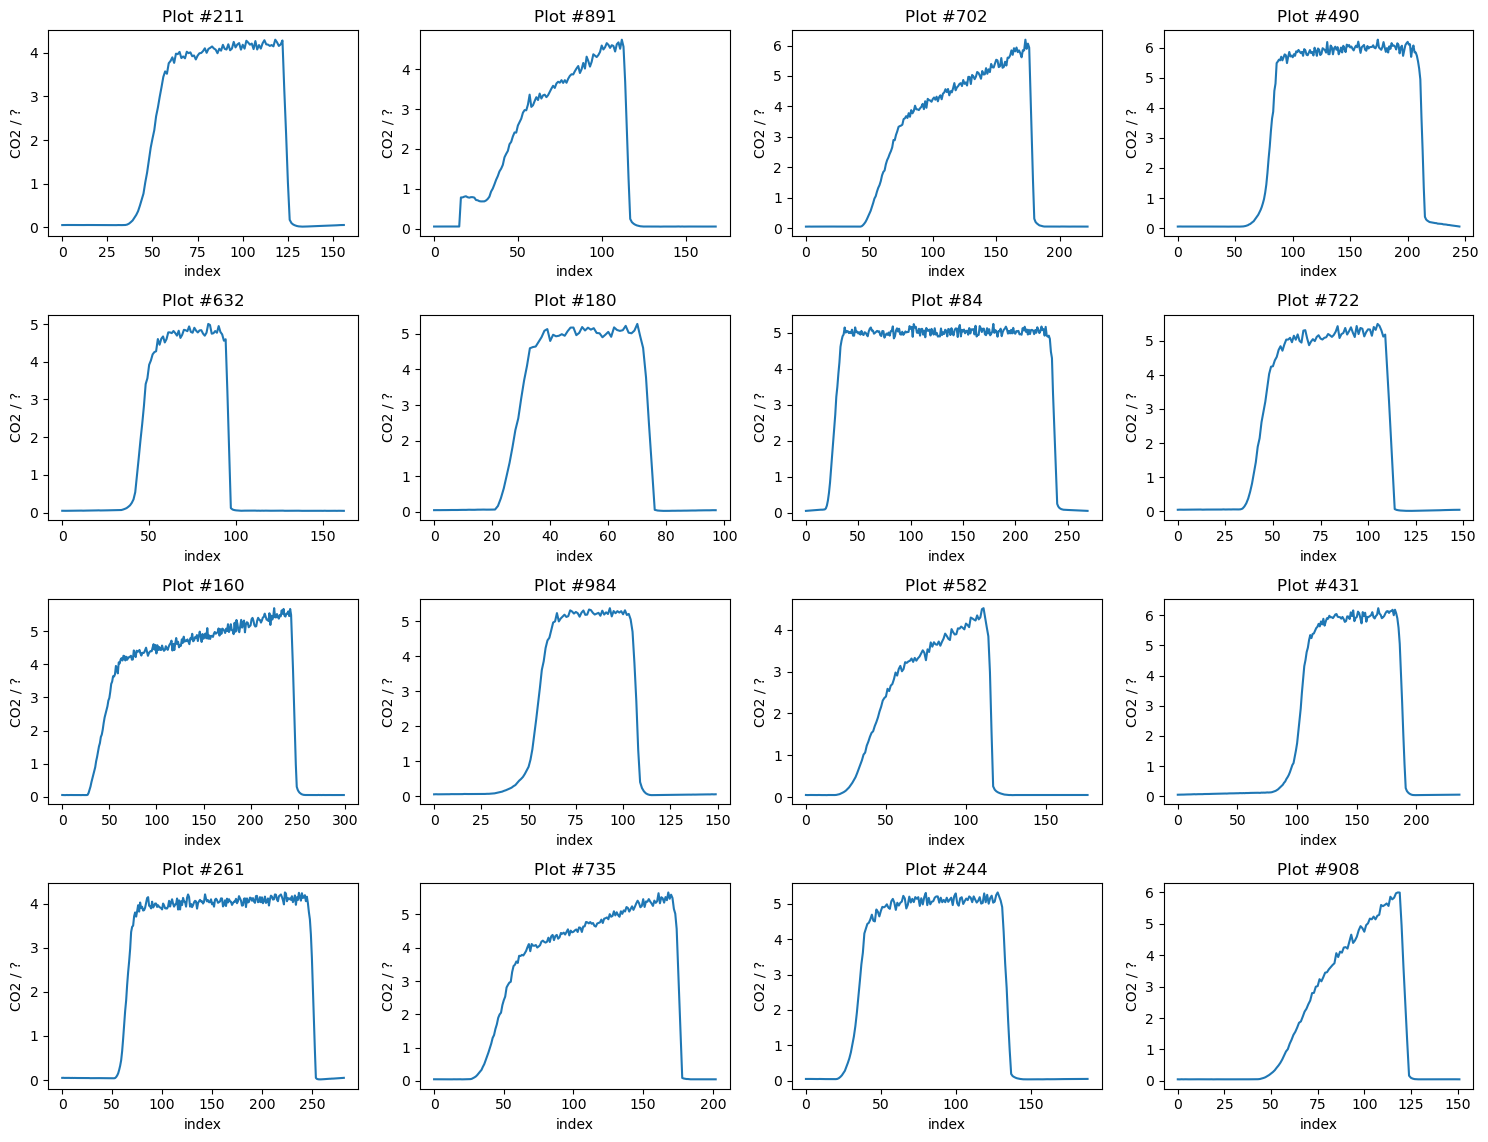

In [35]:
# define (square!) number of plots
plot_num = 16
ncols_rows = int(plot_num**0.5)

# generate random graph indices
# 16 random floats [0,1)
rand_floats = np.random.rand(plot_num) * dataset.shape[0]
rand_ints = rand_floats.astype(int)

# making a list of the first 30 time series 
CO2_data = [list(dataset['breath'][i]) for i in rand_ints]

# creating time data at 50Hz for each time series 
t_data = [np.arange(0,len(series))
    for series in CO2_data]

# Create a 5x2 grid of subplots
fig, axes = plt.subplots(nrows=ncols_rows, ncols=ncols_rows, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot data using Seaborn on each subplot
for i, ax in enumerate(axes):
    sns.lineplot(ax=ax, y=CO2_data[i], x=t_data[i])
    ax.set_title("Plot #{}".format(rand_ints[i]))
    ax.set_xlabel("index")
    ax.set_ylabel("CO2 / ?")
    ax.set_xlim()

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Journal of Graph Shape Features**:

- all appear to be roughly bell shaped, with a plateau in the middle 
- all appear to have random noise on this plateau 
- some appear to have anomalous left shoulders (i = 629, 192, 404, 381)

idea: 
1) investigate the distributions of times for each graph
2) apply rolling average accordingly
3) investigate the distributions of the number of peaks and troughs

could i do something like measure what fraction of the maxCO2val the meanCO2 val is, to give a measure of how much of the graph is roughly zero? lets do this first!

#### 5.2: (mean / max) distribution

In [36]:
# single feature engineering func
def feature_engineering_5_1(dataset):
    
    breath_data = dataset['breath'].apply(np.array)
    
    func_array = [np.max, np.min, np.mean]
    func_labels = ['max', 'min', 'mean']
    output_array = []
    
    for i,func in enumerate(func_array):
        
        output = breath_data.apply(func).to_list()
        output_array.append(output)
    
    # make outputs into dataframe
    output_array = np.array(output_array)
    output_array = output_array.transpose()
    feature_df = pd.DataFrame(data=output_array, columns=func_labels)
    feature_df.index = dataset.index
    
    # custom features
    mean_div_max = (feature_df['mean'] / feature_df['max']).to_frame('(mean / max)')
    custom_list = [mean_div_max, feature_df]
    
    # make full df
    full_feature_df = pd.concat(custom_list, axis=1)

    return full_feature_df

In [37]:
# breath preprocessing functions. 

# bundle: breath_preprocessing(dataset)

def breath_preprocessing(dataset):
    
    breath_data = dataset['breath'].apply(no_nulls)
#     dataset = dataset[breath_data.apply(pos_bool_mask)]
#     breath_data = dataset['breath'].apply(moving_average)
    
    dataset.loc[:,'breath'] = breath_data
    return dataset

def moving_average(time_series_list, WINDOW=10, CENTER=True):
    
    # convert list to pd.series, then apply rolling average code 
    time_series = pd.Series(time_series_list)
    moving_average = time_series.rolling(
        window=WINDOW,       
        center=CENTER,      
        min_periods=int(WINDOW/2),  
    ).mean()   
    
    # finally remove inevitable nulls
    moving_average = moving_average[~moving_average.isnull()]
    
    return moving_average.to_list()


# make sure no Nulls, all numeric
def no_nulls(inp_list):
    
    series = pd.Series(inp_list)
    
    # drop nulls, cast as numeric
    series = series.dropna()
    series = series.astype(float)
    
    return series.to_list()

# make sure no Nulls, all numeric
def check_no_nulls(inp_list):
    
    series = pd.Series(inp_list)
    return series.isna().any()

    
def pos_bool_mask(inp_list):
    if np.min(inp_list) < 0:
        return False
    else:
        return True
    
def time_range_calc(timeseries_list, freq=50, threshold_frac=0.05):
    
    # make array
    array = np.array(timeseries_list)
    
    # find minimum value considered nonzero, given frac of max-min
    threshold_val = threshold_frac * (np.max(array) - np.min(array))
    
    # mask for values over threshold
    # values are already in time order
    # first and last values are the first and last at the threshold, i.e. start and end of series
    over_thresh_array = array[array > threshold_val]
    
    # time elapsed (s) is (num_vals - 1) / freq (Hz)
    total_time_elapsed = (len(over_thresh_array) - 1) / freq
    
    return total_time_elapsed

def redefine_series(func_array, series):
    for func in func_array:
        series = series.apply(func)
        pd.Series(series[0]).plot();
    return series

def range_val(inp_list):
    array = np.array(inp_list)
    return (np.max(array) - np.min(array))

In [38]:
# try to slightly tweak breath preprocessing
# kill nulls 
dataset = original_dataset.copy()
prepd_dataset = breath_preprocessing(dataset)

features = feature_engineering_5_1(prepd_dataset)
features.head()

,(mean / max),max,min,mean
0,0.250698,4.772306,0.047135,1.196408
1,0.612407,5.100980,0.048464,3.123874
2,0.392740,4.462915,-0.723444,1.752765
3,0.476656,5.232965,0.047693,2.494326
4,0.545100,5.489605,0.047820,2.992382


In [39]:
# spread of (mean / max) characteristic
features = feature_engineering_5_1(prepd_dataset)
features.head()

features = features['(mean / max)']

def get_distrib(ds, feature_name_str):
    
    features = ds
    
    func_outputs = [features.min(), features.max(), features.std(), features.mean()]
    names = ['min', 'max', 'std', 'mean']

    print('Features of {} characteristic of time series:\n'.format(feature_name_str))

    for i, func in enumerate(func_outputs):
        print('{:}: {:.3f}'.format(names[i], func))

interesting, but wont use now...

## Epilogue

In [40]:
notebook_end_time = time.time()
total_runtime = notebook_end_time - notebook_start_time
print(f"Total runtime: {total_runtime:.2f} seconds")

Total runtime: 32.43 seconds
